In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [2]:
import ktrain
from ktrain import text

using Keras version: 2.2.4-tf


# Predicting Wine Prices from Textual Descriptions

This notebook shows an example of **text regression** in *ktrain*.  Given a textual description of a wine, we will attempt to predict its price.  The data is available from FloydHub [here](https://www.floydhub.com/floydhub/datasets/wine-reviews/1/wine_data.csv).

## Clean and Prepare the Data

We will simply perform the same data preparation as performed by the [original FloydHub example notebook](https://github.com/floydhub/regression-template) that inspired this exmaple.

In [3]:
import pandas as pd
import numpy as np
path = 'data/wine/wine_data.csv'  # ADD path/to/dataset
data = pd.read_csv(path)
data = data.sample(frac=1., random_state=0)
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
8486,8486,Italy,"Made entirely from Nero d'Avola, this opens wi...",Violino,89,20.0,Sicily & Sardinia,Vittoria,NaN,Nero d'Avola,Paolo Calì
148584,148585,Portugal,Warre's seems to have found just the right for...,Otima 20-year old tawny,90,42.0,Port,NaN,NaN,Port,Warre's
18353,18353,Italy,A more evolved and sophisticated expression of...,Campogrande,87,23.0,Veneto,Soave Superiore,NaN,Garganega,Sandro de Bruno
5281,5281,Spain,Red-fruit and citrus aromas create an astringe...,NaN,84,12.0,Northern Spain,Ribera del Duero,NaN,Tempranillo,Condado de Oriza
87768,87768,US,Lightly funky and showing definite signs of ea...,Lia's Vineyard,89,35.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Seven of Hearts


In [4]:
# Clean it from null values
data = data[pd.notnull(data['country'])]
data = data[pd.notnull(data['price'])]
data = data.drop(data.columns[0], axis=1) 
variety_threshold = 500 # Anything that occurs less than this will be removed.
value_counts = data['variety'].value_counts()
to_remove = value_counts[value_counts <= variety_threshold].index
data.replace(to_remove, np.nan, inplace=True)
data = data[pd.notnull(data['variety'])]

# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

# Train features
description_train = data['description'][:train_size]
variety_train = data['variety'][:train_size]

# Train labels
labels_train = data['price'][:train_size]

# Test features
description_test = data['description'][train_size:]
variety_test = data['variety'][train_size:]

# Test labels
labels_test = data['price'][train_size:]

x_train = description_train.values
y_train = labels_train.values
x_test = description_test.values
y_test = labels_test.values

Train size: 95646
Test size: 23912


## STEP 1: Preprocess the Data

In [5]:
trn, val, preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                          x_test=x_test, y_test=y_test,
                                          ngram_range=3, 
                                          maxlen=200, 
                                          max_features=35000)

task: text regression (supply class_names argument if this is supposed to be classification task)
language: en
Word Counts: 30953
Nrows: 95646
95646 train sequences
train sequence lengths:
	mean : 41
	95percentile : 62
	99percentile : 74
Adding 3-gram features
max_features changed to 1769319 with addition of ngrams
Average train sequence length with ngrams: 120
train (w/ngrams) sequence lengths:
	mean : 121
	95percentile : 183
	99percentile : 219
x_train shape: (95646,200)
y_train shape: 95646
23912 test sequences
test sequence lengths:
	mean : 41
	95percentile : 62
	99percentile : 73
Average test sequence length with ngrams: 111
test (w/ngrams) sequence lengths:
	mean : 112
	95percentile : 172
	99percentile : 207
x_test shape: (23912,200)
y_test shape: 23912


## STEP 2: Create a Text Regression Model and Wrap in Learner

In [6]:
text.print_text_regression_models()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
linreg: linear text regression using a trainable Embedding layer
bigru: Bidirectional GRU with pretrained word vectors [https://arxiv.org/abs/1712.09405]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face [https://arxiv.org/abs/1910.01108]


In [7]:
model = text.text_regression_model('linreg', train_data=trn, preproc=preproc)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=256)

maxlen is 200
done.


Lower the `batch size` above if you run out of GPU memory.

## STEP 3: Estimate the LR

In [8]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 95646 samples
Epoch 1/1024
95646/95646 [==============================] - 8s 81us/sample - loss: 2627.6407 - mae: 34.2769
Epoch 2/1024
95646/95646 [==============================] - 7s 70us/sample - loss: 2610.0313 - mae: 34.0299
Epoch 3/1024
95646/95646 [==============================] - 7s 70us/sample - loss: 2148.5174 - mae: 26.8848
Epoch 4/1024
95646/95646 [==============================] - 7s 71us/sample - loss: 1158.6146 - mae: 15.1160
Epoch 5/1024
15360/95646 [===>..........................] - ETA: 5s - loss: 4022.5116 - mae: 36.6476

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


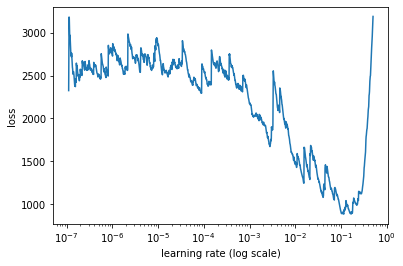

In [9]:
learner.lr_plot()

## STEP 4: Train and Inspect the Model

In [10]:
learner.fit_onecycle(0.03, 10)



begin training using onecycle policy with max lr of 0.03...
Train on 95646 samples, validate on 23912 samples
Epoch 1/10
95646/95646 [==============================] - 8s 79us/sample - loss: 1556.0435 - mae: 19.2369 - val_loss: 984.7442 - val_mae: 15.1122
Epoch 2/10
95646/95646 [==============================] - 8s 79us/sample - loss: 1052.5454 - mae: 13.0505 - val_loss: 808.2142 - val_mae: 12.5382
Epoch 3/10
95646/95646 [==============================] - 7s 76us/sample - loss: 809.7949 - mae: 9.4578 - val_loss: 695.8532 - val_mae: 10.8098
Epoch 4/10
95646/95646 [==============================] - 8s 80us/sample - loss: 616.9707 - mae: 6.6427 - val_loss: 621.5498 - val_mae: 9.9253
Epoch 5/10
95646/95646 [==============================] - 7s 78us/sample - loss: 471.5737 - mae: 4.8021 - val_loss: 582.4865 - val_mae: 9.9948
Epoch 6/10
95646/95646 [==============================] - 8s 79us/sample - loss: 369.3043 - mae: 4.1017 - val_loss: 572.5836 - val_mae: 10.4219
Epoch 7/10
95646/95646

Our MAE is roughly 10, which means our model's predictions are about $10 off on average.  This isn't bad considering there is a wide range of wine prices and predictions are being made purely from text descriptions. 

Let's examine the wines we got the most wrong.

In [11]:
learner.view_top_losses(n=3, preproc=preproc)

----------
id:6695 | loss:675000.75 | true:980.0 | pred:158.42)

this was a great vintage port year and this white port which was bottled in 2015 has hints of the firm tannins and structure that marked out the year it also has preserved an amazing amount of freshness still suggesting orange marmalade flavors these are backed up by the fine concentrated old wood tastes the wine is of course ready to drink
----------
id:19469 | loss:524528.9 | true:775.0 | pred:50.76)

perfumed florals mingle curiously with deep dusty mineral notes on this bracing tba sunny nectarine and tangerine flavors are mouthwatering and juicy struck with acidity then plunged into of sweet honey and nectar it's a delightful sensory roller coaster that feels endless on the finish
----------
id:3310 | loss:400394.03 | true:848.0 | pred:215.23)

full of ripe fruit opulent and concentrated this is a fabulous and impressive wine it has a beautiful line of acidity balanced with ripe fruits the wood aging is subtle just a

It looks like our model has trouble with expensive wines, which is understandable given the descriptions of them, which may  not differ much from less expensive wines.

## STEP 5: Making Predictions

In [12]:
predictor = ktrain.get_predictor(learner.model, preproc)

Let's make a prediction for a random wine in the validation set.

In [13]:
idx = np.random.randint(len(x_test))
print('Description: %s' % (x_test[idx]))
print('Actual Price: %s' % (y_test[idx]))

Description: This Millesimato sparkling blend of Pinot Nero and oak-aged Chardonnay delivers a generous and creamy mouthfeel followed by refined aromas of dried fruit and baked bread. This is a beautiful wine to serve with tempura appetizers.
Actual Price: 52.0


Our prediction for this wine:

In [14]:
predictor.predict(x_test[idx])

array([52.698753], dtype=float32)